# Predictive Modeling for Critical Dimension (CD) Quality Assurance

- **Background**: Precision in semiconductor manufacturing is crucial for product reliability. Wafer etching requires strict dimensional tolerances.
- **Critical Dimensions (CDs)**: CDs represent the physical dimensions of etched features. Deviations can lead to defective products.  
`Example of semiconductor features that need precise measurements`  
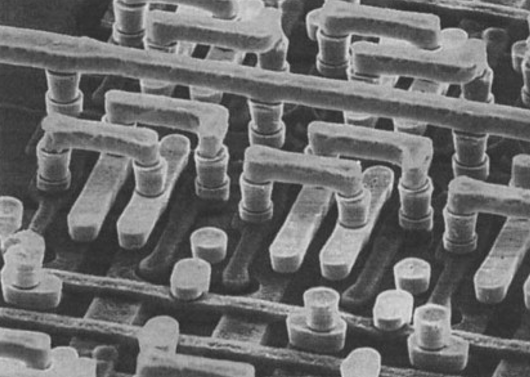
- **Measurement Challenges**: Measuring CDs on all wafers is impractical due to time constraints, creating the need for a predictive solution.

- **Challenge**: Limited CD measurements may miss defects, resulting in waste and downstream issues.
- **Proposed Solution**: Develop a predictive model using etching machine sensor data to estimate CDs and identify out-of-spec wafers for preventive action.

### Use Case
- **Objective**: Create a model that can correlate sensor data with CDs for real-time monitoring and proactive intervention.
- **Preventive Action**: Alerts will notify engineers if predicted CDs are out of spec, allowing adjustments to reduce defects.

### Data Availability
- **Synthetic Sensor Data**: Generated to simulate sensor readings.
- **Historical CD Data**: Used as the target variable with upper, lower, and target specifications.

### Methodology
- **Neural Network**: Selected for its ability to model complex relationships in high-dimensional data.
- **Evaluation Metrics**: Use MAE and RMSE for accuracy, with a focus on recall for identifying out-of-spec wafers.

### Expected Outcomes
- **Prediction Accuracy**: Reduce reliance on physical measurements.
- **Defective Reduction**: Minimize waste by predicting out-of-spec wafers.
- **Real-time Monitoring**: Enable rapid interventions and continuous process improvement.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helper_functions import (
    sensor_limits,
    cd_targets,
    generate_synthetic_data,
    add_noise_to_samples,
    generate_out_of_spec_samples,
    add_cd_values,
    add_cd_spec_labels
)

## Generating synthetic data
- To generate synthetic training data that is realistic some helper functions have been created in the `helper_functions.py` file.  

- `sensor_limits` is a dictionary that contains arbitrary chamber step/sensor names as keys with a list of numerical values that indicate the upper spec limit, lower spec limit and target values for the respective sensor at that particular step.  
- `cd_targets` is a dictionary that contains the upper limit, lower limit and target for each of the four critical dimensions that will be the target features for the model. This will be used in generating data as well.
- `generate_synthetic_data` is a function that will generate a given number of samples using the `sensor_limits` dictionary.
    - One sample consists of a value for each item in the dictionary
    - If upper and lower spec limits are not the same (which indicates a reading should be zero or constant) sensor readings will be assigned random values within the spec limits in a normal distribution.
    - the `RF` value is not a sensor, but a sum of Radio Frequency hours since the last maintenance. This is an indicator of the chambers performace with very low or very high values likey perfoming poorly. To indicate this, the function will pick a random sensor and adjust the reading to be outside of spec limits. This is intended to introduce samples that are out of spec, which are the key values we want to identify with the model
- `add_noise_to_samples` is a function that will take the synthetic data generated by `generate_synthetic_data` as an argument and add noise to a given number of samples. This is a helper function to add noise to training data and prevent over fitting.  
- `generate_out_of_spec_samples` is a function that will add additional out of spec samples if the synthetic data generated does not have enough
- `add_cd_values` is a function that will assign values for the four critical dimensions that are our target features. function will assign values based on the sensor data. If readings are very high or very low, CD values will be assigned farther from their target.
- `add_cd_spec_labels` function that will add a column to the data that indicates if a sample is out of spec or not

In [2]:
# # generate synthetic data
# num_wafers = 90000
# data = generate_synthetic_data(sensor_limits, num_wafers)

# # add out-of-spec samples
# num_out_of_spec_samples = 10000
# data = generate_out_of_spec_samples(data, sensor_limits, num_out_of_spec_samples)

# # add CD values
# data = add_cd_values(data, sensor_limits, cd_targets)

# # add CD InSpec labels
# data = add_cd_spec_labels(data, cd_targets)

# # save the data to file so we can come back to it later
# data.to_csv('./training_data/synthetic_data.csv', index=False)

### Exploratory Data Analysis
1. Understand the data
2. Check for missing values
3. Visualize data
4. Correlation analysis
    - Sensor / CD relationships

#### Understand the data

In [3]:
# import data from file so we have a baseline to work with
df = pd.read_csv('./training_data/synthetic_data.csv')
df.shape

(100000, 81)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 81 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   RF                           100000 non-null  float64
 1   STEP1_Current_avg            100000 non-null  float64
 2   STEP1_Etch_Time              100000 non-null  float64
 3   STEP1_Lower_Edge_Temp_Avg    100000 non-null  float64
 4   STEP1_Lower_Temp_Avg_E       100000 non-null  float64
 5   STEP1_Lower_VPP_Hardlimit_E  100000 non-null  float64
 6   STEP1_Lower_VPP_Std_E        100000 non-null  float64
 7   STEP1_Press_std              100000 non-null  float64
 8   STEP1_Upper_VPP_Hardlimit_E  100000 non-null  float64
 9   STEP1_press_avg              100000 non-null  float64
 10  STEP2_Current_avg            100000 non-null  float64
 11  STEP2_Etch_Time              100000 non-null  float64
 12  STEP2_Lower_Edge_Temp_Avg    100000 non-null  float64
 13  

In [5]:
df.describe()

,RF,STEP1_Current_avg,STEP1_Etch_Time,STEP1_Lower_Edge_Temp_Avg,STEP1_Lower_Temp_Avg_E,STEP1_Lower_VPP_Hardlimit_E,STEP1_Lower_VPP_Std_E,STEP1_Press_std,STEP1_Upper_VPP_Hardlimit_E,STEP1_press_avg,...,STEP8_Lower_Temp_Avg_E,STEP8_Lower_VPP_Hardlimit_E,STEP8_Lower_VPP_Std_E,STEP8_Press_std,STEP8_Upper_VPP_Hardlimit_E,STEP8_press_avg,CD1,CD4,CD5,CD151
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,498.684738,0.194346,39.999983,18.006983,18.007016,0.0,0.0,0.143515,1817.551393,19.992716,...,57.000817,228.556768,1.545124,0.131456,1530.861419,39.992775,0.038620,0.028563,0.028566,0.040152
std,302.963154,0.265363,0.008449,0.012167,0.012066,0.0,0.0,0.091939,26.116222,0.013081,...,0.052848,4.332588,0.537133,0.079647,26.688388,0.012923,0.000759,0.000395,0.000414,0.000956
min,6.718924,-0.500000,39.860326,17.975000,17.975000,0.0,0.0,-0.100000,1713.300000,19.875000,...,56.825000,209.150000,-0.750000,-0.115000,1419.925000,39.875000,0.031094,0.024643,0.024459,0.030671
25%,224.713987,0.000000,40.000000,18.000000,18.000000,0.0,0.0,0.061723,1800.891330,19.988516,...,56.965865,225.848248,1.205349,0.076642,1513.990372,39.988608,0.038421,0.028459,0.028457,0.039901
50%,500.571833,0.097989,40.000000,18.000000,18.000046,0.0,0.0,0.129184,1817.580302,19.999969,...,56.999846,228.611053,1.544477,0.129356,1530.999270,39.999959,0.038578,0.028541,0.028543,0.040099
75%,771.658811,0.326341,40.000000,18.011302,18.011458,0.0,0.0,0.197961,1834.222660,20.000000,...,57.034161,231.343713,1.888328,0.181652,1547.910073,40.000000,0.038738,0.028624,0.028630,0.040300
max,987.847013,2.500000,40.130536,18.125000,18.125000,0.0,0.0,0.800000,1932.300000,20.025000,...,57.275000,245.450000,3.750000,0.575000,1644.175000,40.025000,0.047314,0.033091,0.033309,0.051102


##### About the data
- Since the data was artificially constructed, there are no nulls and datatypes are appropriate for training a model.  

- Data is realistic but will need to check if there is enough variation
- The one thing that generating sythetic data does not capture is the dynamic nature of scrap events and causes. Becuase there is a high chance for human error during maintenance of machines, that is not considered in this data since there is not good way to anticipate what kind of human error might occur.
- This data is also considering the relationship between every sensor and its effect on the resulting CD measurements equally. In reality there are some sensor measurements that have a much higher impact than others, but this takes a level of domain knowledge that I just do not have

#### Check for missing values

In [6]:
# check for missing values and duplicate rows
nulls = df.isnull().sum().to_dict()
for key, value in nulls.items():
    print(key, ' - ', value)


RF  -  0
STEP1_Current_avg  -  0
STEP1_Etch_Time  -  0
STEP1_Lower_Edge_Temp_Avg  -  0
STEP1_Lower_Temp_Avg_E  -  0
STEP1_Lower_VPP_Hardlimit_E  -  0
STEP1_Lower_VPP_Std_E  -  0
STEP1_Press_std  -  0
STEP1_Upper_VPP_Hardlimit_E  -  0
STEP1_press_avg  -  0
STEP2_Current_avg  -  0
STEP2_Etch_Time  -  0
STEP2_Lower_Edge_Temp_Avg  -  0
STEP2_Lower_Temp_Avg_E  -  0
STEP2_Lower_VPP_Hardlimit_E  -  0
STEP2_Lower_VPP_Std_E  -  0
STEP2_Press_std  -  0
STEP2_Upper_VPP_Hardlimit_E  -  0
STEP2_press_avg  -  0
STEP3_Current_avg  -  0
STEP3_Etch_Time  -  0
STEP3_Lower_Edge_Temp_Avg  -  0
STEP3_Lower_Temp_Avg_E  -  0
STEP3_Lower_VPP_Hardlimit_E  -  0
STEP3_Lower_VPP_Std_E  -  0
STEP3_Press_std  -  0
STEP3_Upper_VPP_Hardlimit_E  -  0
STEP3_press_avg  -  0
STEP4_Current_avg  -  0
STEP4_Etch_Time  -  0
STEP4_Lower_Edge_Temp_Avg  -  0
STEP4_Lower_Temp_Avg_E  -  0
STEP4_Lower_VPP_Hardlimit_E  -  0
STEP4_Lower_VPP_Std_E  -  0
STEP4_Press_std  -  0
STEP4_Upper_VPP_Hardlimit_E  -  0
STEP4_press_avg  -  0
STE

In [7]:
dupe_rows = df.duplicated().sum()
print('Number of duplicate rows: ', dupe_rows)

Number of duplicate rows:  0


- Data is free of null values and duplicate rows

#### Visualize data

In [8]:
cd_columns = ['CD1', 'CD4', 'CD5', 'CD151']

In [9]:
# import math

# sensor_columns = [col for col in df.columns if 'InSpec' not in col]
# num_sensors = len(sensor_columns)

# num_cols = 3
# num_rows = math.ceil(num_sensors / num_cols)

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
# axes = axes.flatten()

# for i, sensor in enumerate(sensor_columns):
#     axes[i].hist(df[sensor], bins=30, edgecolor='k', alpha=0.7)
#     axes[i].set_title(f'Distribution of {sensor}')
#     axes[i].set_xlabel(sensor)
#     axes[i].set_ylabel('Frequency')

# # Hide any unused subplots
# for i in range(num_sensors, num_rows * num_cols):
#     fig.delaxes(axes[i])

# plt.tight_layout()
# plt.show()

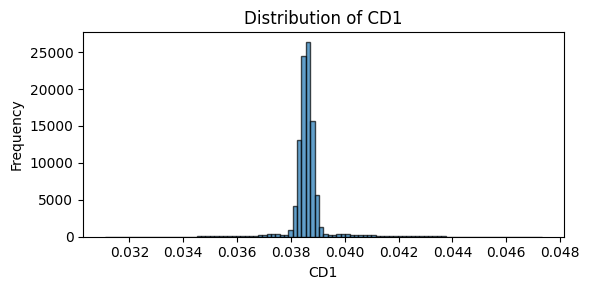

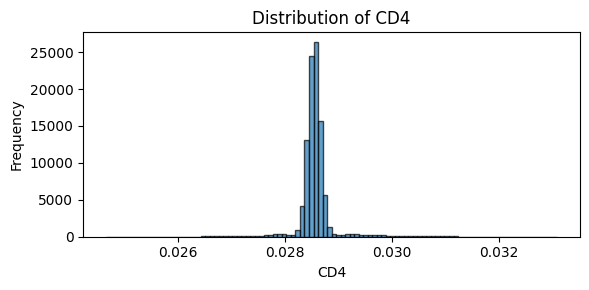

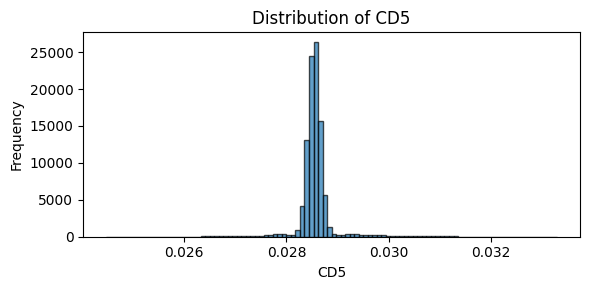

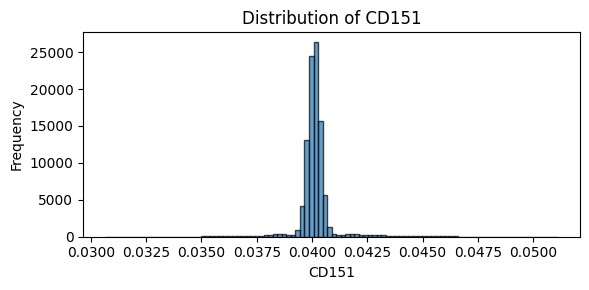

In [10]:
# closer look at the target features
for cd in cd_columns:
    plt.figure(figsize=(6, 3))
    plt.hist(df[cd], bins=100, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of {cd}')
    plt.xlabel(cd)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

- Distribution of each of the features is mostly a normal distribution for sensors that have variable outputs.
- Some sensors like etch time and voltage peak to peak (VPP) are easy to control or, in the case of voltage, are either on or off so they have long tailed distributions within a narrow range.
- Distributions for the target CDs are normal with a very narrow range which is what is expected because they have a goal target/upper limit/lower limit and should not vary from that range by much

#### Correlation analysis

In [11]:
# compute correlation matrix
cols = df.columns.tolist()
corr_matrix = df[cols].corr()

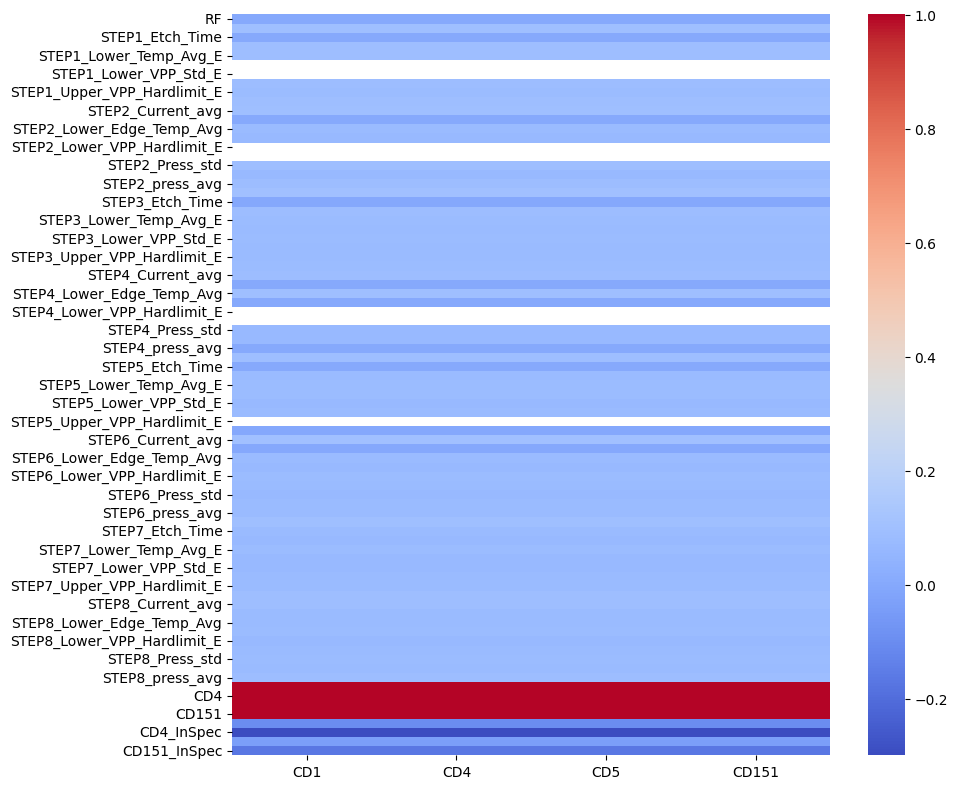

In [12]:
# plot the correlation matrix with cd columns on the X-axis
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[cd_columns], annot=False, cmap='coolwarm')
plt.tight_layout()
plt.show()

- appears that the voltage peak to peak (VPP) and hardlimit columns have no correlation to the target features.
- will drop these features

In [13]:
cols = df.columns.tolist()
cols = [col for col in cols if 'VPP' not in col]
df = df[cols]

### Preprocessing data
- there are no categorical features so there is no need for encoded.
- Scale data using standard scaler
- Since it is vitally important that the models place greater weight on samples where the CD measurements are above or below their spec limits (as opposed to on target) define a custom loss function

In [14]:
# select features
sensor_columns = [col for col in df.columns if 'CD' not in col]

In [15]:
from sklearn.model_selection import train_test_split

# Split data
X = df[sensor_columns]
y = df[cd_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# scale the data
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale target variables
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)

# save the scaler to file so they can be used later for inverse scaling predictions from the model
joblib.dump(scaler, './scalers/scaler.pkl')
joblib.dump(target_scaler, './scalers/target_scaler.pkl')

['./scalers/target_scaler.pkl']

In [17]:
# convert scaled data to dataframes for easy viewing. these will not be used in training at all
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

y_train_df = pd.DataFrame(y_train_scaled, columns=y_train.columns, index=y_train.index)
y_test_df = pd.DataFrame(y_test_scaled, columns=y_test.columns, index=y_test.index)

### Define and train model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise

In [19]:
import tensorflow as tf

# check if gpu is available
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.10.1
Num GPUs Available:  1


#### Custom loss function
- The most important thing about making predictions is that the model can predict samples that are either above or below their respective spec limits. These are the critical samples that we are trying to predict  

- Use a custom loss function that will weight any sample that is either above or below its spec limits much more heavily than samples that are within spec or near its target

`Approach:`
- **Sample Weighting**: Assign a weight to each sample based on whether it is above or below spec limits
- **Higher Weights for Out-of-Spec Samples**: Samples outside the spec limits receive higher weights

In [30]:
from custom_loss import WeightedMSELoss

custom_loss_fn = WeightedMSELoss(cd_targets=cd_targets, higher_weight=50.0, base_weight=1.0)

In [40]:
# Define the model
model = Sequential()

# input layer
model.add(Dense(512, input_dim=X_train_scaled.shape[1], activation='LeakyReLU'))

# hidden layers
model.add(GaussianNoise(0.02))
model.add(Dense(512, activation='LeakyReLU'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GaussianNoise(0.01))
model.add(Dense(256, activation='LeakyReLU'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GaussianNoise(0.001))
model.add(Dense(128, activation='LeakyReLU'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GaussianNoise(0.001))
model.add(Dense(64, activation='LeakyReLU'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='LeakyReLU'))
model.add(Dense(16, activation='LeakyReLU'))
model.add(Dense(8, activation='LeakyReLU'))

# output layer
model.add(Dense(4, activation='linear'))  # output neurons equal to number of CDs

# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.compile(optimizer='adam', loss=custom_loss_fn, metrics=['mae'])

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=300,
    batch_size=128,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/300
625/625 [==============================] - 5s 6ms/step - loss: 36.6693 - mae: 0.4185 - val_loss: 29.8023 - val_mae: 0.3836 - lr: 0.0010
Epoch 2/300
625/625 [==============================] - 3s 5ms/step - loss: 31.0650 - mae: 0.3709 - val_loss: 26.8715 - val_mae: 0.3552 - lr: 0.0010
Epoch 3/300
625/625 [==============================] - 4s 6ms/step - loss: 29.1473 - mae: 0.3602 - val_loss: 28.9325 - val_mae: 0.3658 - lr: 0.0010
Epoch 4/300
625/625 [==============================] - 3s 5ms/step - loss: 28.1742 - mae: 0.3524 - val_loss: 25.2773 - val_mae: 0.3364 - lr: 0.0010
Epoch 5/300
625/625 [==============================] - 4s 6ms/step - loss: 27.0970 - mae: 0.3458 - val_loss: 26.3901 - val_mae: 0.3361 - lr: 0.0010
Epoch 6/300
625/625 [==============================] - 4s 6ms/step - loss: 26.3977 - mae: 0.3406 - val_loss: 25.9544 - val_mae: 0.3357 - lr: 0.0010
Epoch 7/300
625/625 [==============================] - 4s 6ms/step - loss: 25.7342 - mae: 0.3375 - val_loss: 26.

### Evaluation

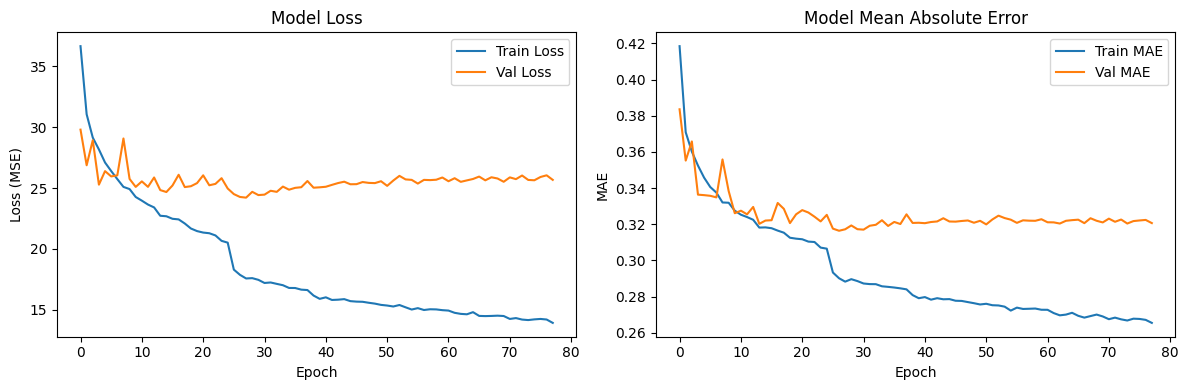

In [42]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [43]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Test Loss (MSE): {test_loss}')
print(f'Test MAE: {test_mae}')

625/625 [==============================] - 2s 2ms/step - loss: 24.2093 - mae: 0.3172
Test Loss (MSE): 24.209251403808594
Test MAE: 0.3172051012516022


In [44]:
# save model to a file and then load it back to make sure it works
model.save('./models/trained_model.h5')
model = tf.keras.models.load_model('./models/trained_model.h5')

In [45]:
# Predict on test data
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform predictions and actual values
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test_scaled)

625/625 [==============================] - 1s 2ms/step


In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# dict to store metrics
mse = {}
rmse = {}
mape = {}

cd_list = cd_columns

for i, cd in enumerate(cd_list):
    mse[cd] = mean_squared_error(y_test_actual[:, i], y_pred[:, i])
    rmse[cd] = np.sqrt(mse[cd])
    mape[cd] = mean_absolute_percentage_error(y_test_actual[:, i], y_pred[:, i])
    print(f'{cd} - MSE: {mse[cd]:.6f}, RMSE: {rmse[cd]:.6f}, MAPE: {mape[cd]:.4f}')

CD1 - MSE: 0.000000, RMSE: 0.000531, MAPE: 0.0063
CD4 - MSE: 0.000000, RMSE: 0.000277, MAPE: 0.0044
CD5 - MSE: 0.000000, RMSE: 0.000290, MAPE: 0.0046
CD151 - MSE: 0.000000, RMSE: 0.000669, MAPE: 0.0076


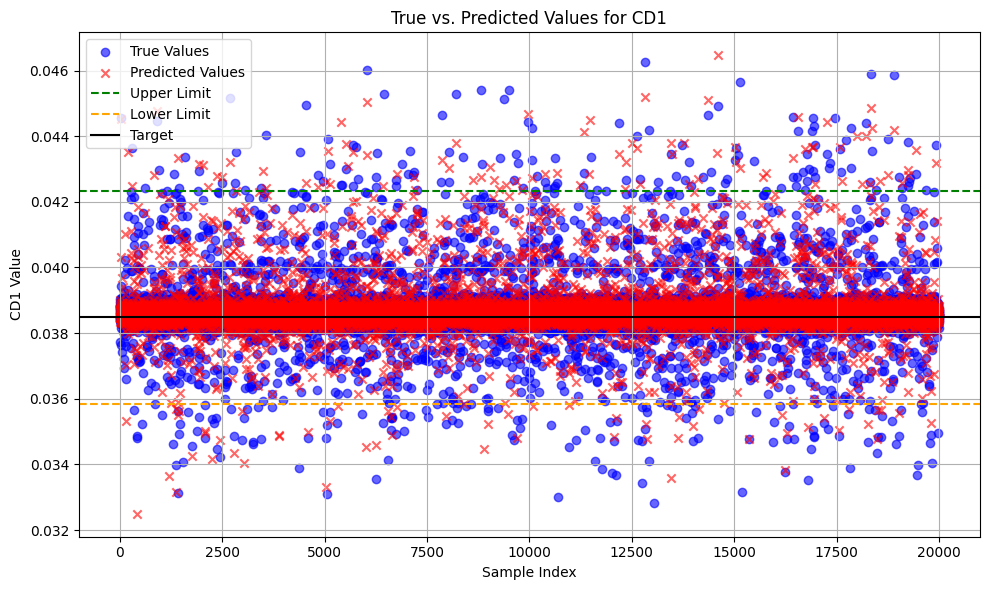

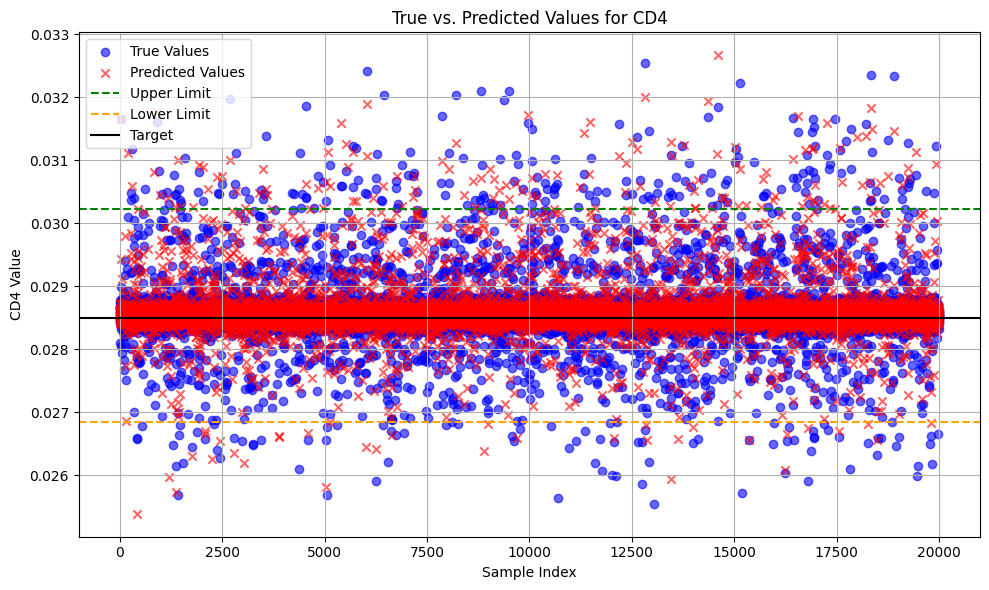

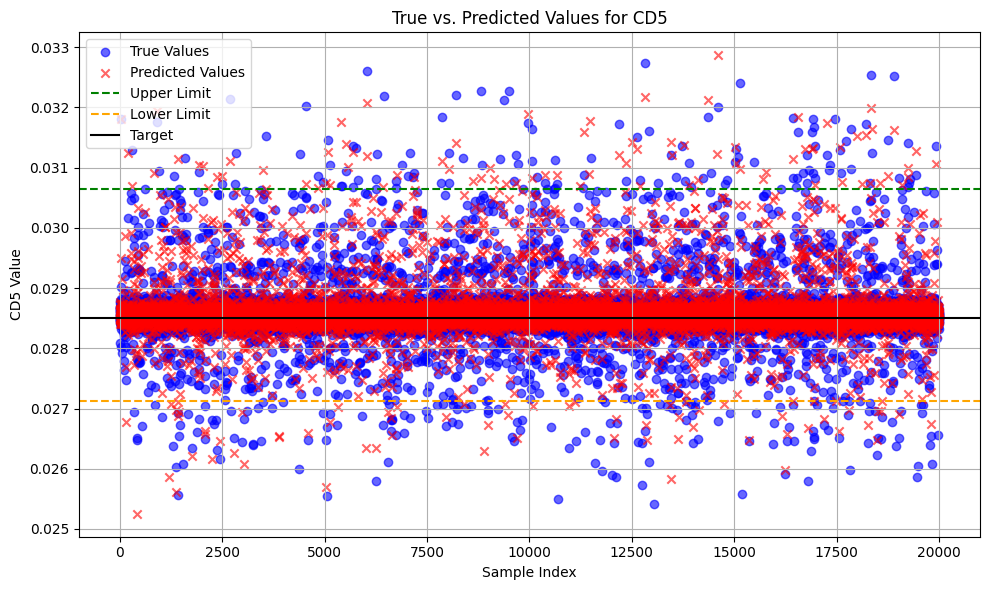

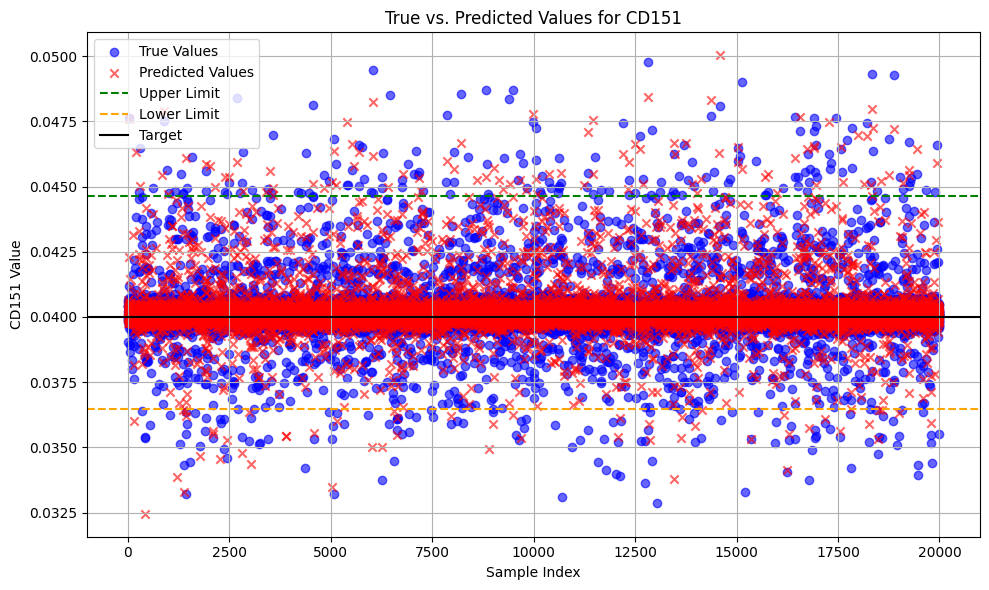

In [47]:
from helper_functions import plot_helper

plot_helper(y_true=y_test_actual, y_pred=y_pred, cd_columns=cd_columns, cd_targets=cd_targets)

### Results
- model is predicting the out of spec samples well, which is the most important thing.
- the model is very accurate and this is probably a result of the low complexity of the data. There is a clear signal in the data that if the sensors are out of spec then the CD measurements should also be out of spec